In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance
import riskfolio as rp
from prophet import Prophet
from typing import List

In [10]:
stocks: List[str] = ["AAPL","MSFT","GOOG"] # List of stocks in the desired portfolio
historical_period: str = "5y" # Period to look back in the history of prices. Can be set like 1m, 3m for months; 1y,3y for years or max for all available. Default = 5y
future_period: int = 365 # Forecasting period in days. Keep in mind longer the period less accurate the results
current_dictionary = {}
future_dictionary = {}

In [11]:
def get_current_prices (stock: str,period: str = "5y"):
    '''
    Function to download and prepare the data for current prices
    '''
    data = yfinance.download(stock, period=period)[["Adj Close"]]
    data = data.reset_index()
    data = data.rename(columns={"Date":"ds","Adj Close":"y"})
    return data


def get_future_prices (historical_data,period: int = 365):
    '''
    Function to predict the prices
    '''
    model = Prophet()
    model.fit(historical_data)
    future_dates = model.make_future_dataframe(periods=period)
    future_prices = model.predict(future_dates)
    return future_prices[["ds","yhat"]]

def estimate_portfolio(data):
    # Estimate optimal portfolio:
    Y = data.pct_change().dropna()
    print(Y)

    portfolio = rp.Portfolio(returns=Y)

    method_mu: str = "hist"  
    method_cov: str = "hist"

    portfolio.assets_stats(method_mu=method_mu, method_cov=method_cov, d=0.94)

    model: str = "Classic"  # Could be Classic (historical), BL (Black Litterman) or FM (Factor Model)
    rm: str = "MV"  # Risk measure used, this time will be variance
    obj: str = "Sharpe"  # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
    hist: bool = True  # Use historical scenarios for risk measures that depend on scenarios
    rf: int = 0  # Risk free rate
    l: int = 0  # Risk aversion factor, only useful when obj is 'Utility'

    w = portfolio.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)
    return w

def plot_portfolio(w):
    '''
    Plot portfolio
    '''
    ax = plt.subplot()
    ax = rp.plot_pie(
        w=w,
        title="Sharpe Mean Variance",
        nrow=25,
        cmap="tab20",
        height=6,
        width=10,
        ax=None,
    )
    plt.show()


In [12]:
for stock in stocks:
    current_dictionary[stock] = get_current_prices(stock,historical_period)
    future_dictionary[stock] = get_future_prices(current_dictionary[stock],future_period)
    
    

[*********************100%***********************]  1 of 1 completed

15:55:21 - cmdstanpy - INFO - Chain [1] start processing


15:55:21 - cmdstanpy - INFO - Chain [1] done processing


[*********************100%***********************]  1 of 1 completed

15:55:23 - cmdstanpy - INFO - Chain [1] start processing


15:55:23 - cmdstanpy - INFO - Chain [1] done processing


[*********************100%***********************]  1 of 1 completed

15:55:24 - cmdstanpy - INFO - Chain [1] start processing


15:55:24 - cmdstanpy - INFO - Chain [1] done processing


In [13]:
current_portfolio = pd.DataFrame()
for i,stock in enumerate(stocks):
    if i == 0:
        data = pd.DataFrame.from_dict(current_dictionary[stock])
        data = data.rename(columns={"y":f"{stock}"})
        current_portfolio = pd.concat([current_portfolio,data],axis=1)       
    else:
        data = pd.DataFrame.from_dict(current_dictionary[stock])
        data = data.drop("ds",axis=1,errors="ignore")
        data = data.rename(columns={"y":f"{stock}"})
        current_portfolio = pd.concat([current_portfolio,data],axis=1)
current_portfolio = current_portfolio.set_index('ds')
current_portfolio

,AAPL,MSFT,GOOG
ds,,,
2018-01-08,41.447342,83.134598,55.347000
2018-01-09,41.442585,83.078079,55.313000
2018-01-10,41.433079,82.701401,55.130501
2018-01-11,41.668430,82.946259,55.276001
2018-01-12,42.098705,84.377647,56.112999
...,...,...,...
2022-12-30,129.929993,239.820007,88.730003
2023-01-03,125.070000,239.580002,89.699997
2023-01-04,126.360001,229.100006,88.709999


In [14]:
future_portfolio = pd.DataFrame()
for i,stock in enumerate(stocks):
    if i == 0:
        data = pd.DataFrame.from_dict(future_dictionary[stock])
        data = data.rename(columns={"yhat":f"{stock}"})
        future_portfolio = pd.concat([future_portfolio,data],axis=1)       
    else:
        data = pd.DataFrame.from_dict(future_dictionary[stock])
        data = data.drop("ds",axis=1,errors="ignore")
        data = data.rename(columns={"yhat":f"{stock}"})
        future_portfolio = pd.concat([future_portfolio,data],axis=1)
future_portfolio = future_portfolio.set_index("ds")
future_portfolio

,AAPL,MSFT,GOOG
ds,,,
2018-01-08,41.615364,87.680125,53.352823
2018-01-09,41.724098,87.125339,53.370293
2018-01-10,41.818074,86.960042,53.563379
2018-01-11,41.694935,86.329079,53.585052
2018-01-12,41.610606,85.949387,53.556936
...,...,...,...
2024-01-02,110.267148,138.328837,35.205124
2024-01-03,110.226067,137.857243,35.228892
2024-01-04,109.969067,136.854450,35.076573


                AAPL      MSFT      GOOG
ds                                      
2018-01-09 -0.000115 -0.000680 -0.000614
2018-01-10 -0.000229 -0.004534 -0.003299
2018-01-11  0.005680  0.002961  0.002639
2018-01-12  0.010326  0.017257  0.015142
2018-01-16 -0.005082 -0.013951 -0.000445
...              ...       ...       ...
2022-12-30  0.002469 -0.004938 -0.002473
2023-01-03 -0.037405 -0.001001  0.010932
2023-01-04  0.010314 -0.043743 -0.011037
2023-01-05 -0.010605 -0.029638 -0.021869
2023-01-06  0.010398 -0.010338 -0.006569

[1258 rows x 3 columns]


c:\Users\sedat\anaconda3\envs\finpred\lib\site-packages\riskfolio\src\PlotFunctions.py:605: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sizes2 = sizes2.append(item)


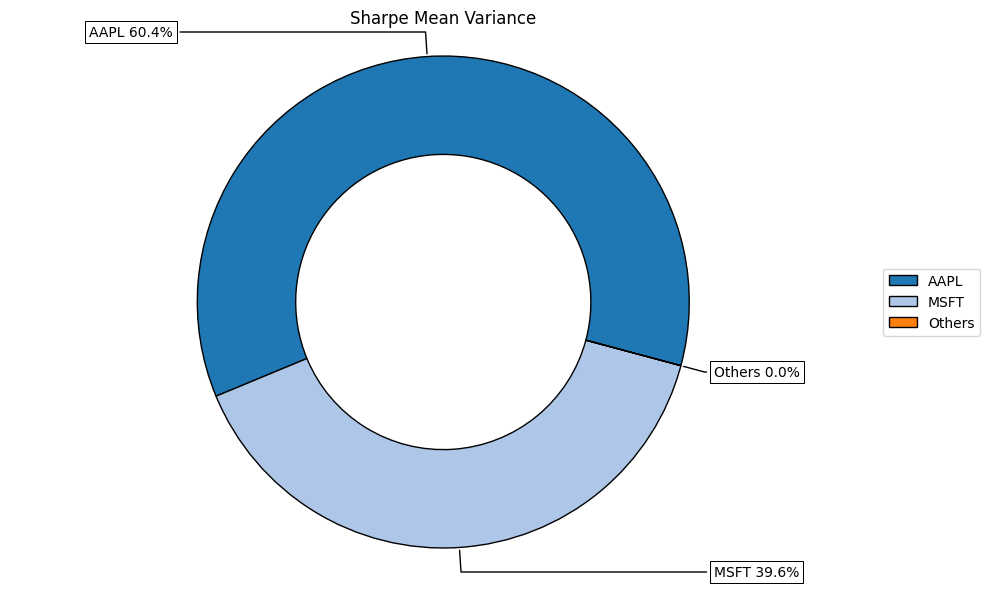

In [15]:
current_estimate = estimate_portfolio(current_portfolio)
current_plot = plot_portfolio(current_estimate)

                AAPL      MSFT      GOOG
ds                                      
2018-01-09  0.002613 -0.006327  0.000327
2018-01-10  0.002252 -0.001897  0.003618
2018-01-11 -0.002945 -0.007256  0.000405
2018-01-12 -0.002023 -0.004398 -0.000525
2018-01-16  0.015056 -0.015631  0.001593
...              ...       ...       ...
2024-01-02 -0.000260 -0.005734 -0.004198
2024-01-03 -0.000373 -0.003409  0.000675
2024-01-04 -0.002332 -0.007274 -0.004324
2024-01-05 -0.001985 -0.005976 -0.005927
2024-01-06  0.009830 -0.034335  0.008034

[1623 rows x 3 columns]


c:\Users\sedat\anaconda3\envs\finpred\lib\site-packages\riskfolio\src\PlotFunctions.py:605: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sizes2 = sizes2.append(item)


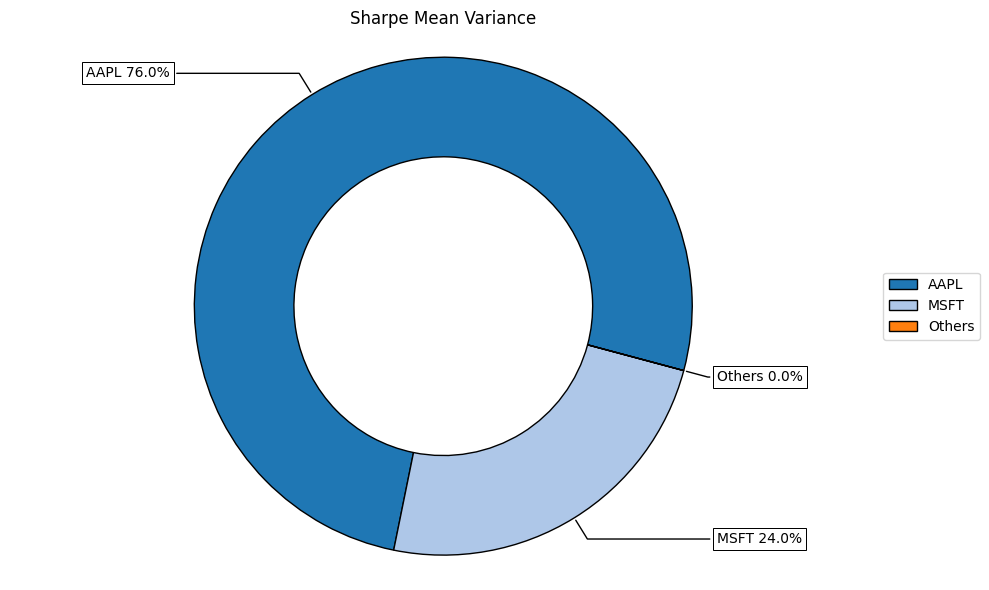

In [16]:
future_estimate = estimate_portfolio(future_portfolio)
future_plot = plot_portfolio(future_estimate)